In [1]:
%matplotlib inline
import numpy as np
from glob import glob
from skimage import io
from matplotlib import pyplot as plt
from helperfuncs import image_slice,imm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, UpSampling2D, merge
from keras.optimizers import Adam

/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocessing of Data

In [3]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')

In [3]:
# Breaking up the 1024x1024 images into four 512x512
#break up images:
image_slice(directory,'image')
image_slice(directory,'label')

done!
done!


In [4]:
image_files = glob(directory+'/sliced_images/*.png')
mask_files = glob(directory + '/sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

In [5]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(333, 512, 512, 1) (333, 512, 512, 1) (111, 512, 512, 1) (111, 512, 512, 1)


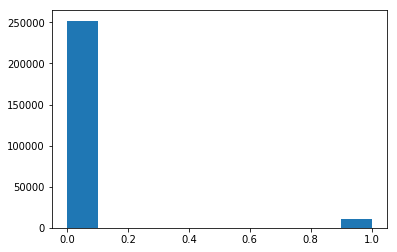

In [28]:
_ = plt.hist(trainY[0,:,:,:].reshape([512,512]).flatten())

In [23]:
type(trainX[1,1,0,0])

numpy.float32

## Data Augmentation

In [24]:
# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90.,
                     rescale=1./255,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
batch_size = 1
# image_datagen.fit(trainX, augment=True, seed=seed)
# mask_datagen.fit(trainY, augment=True, seed=seed)

image_generator = image_datagen.flow(
    trainX,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

mask_generator = mask_datagen.flow(
    trainY,
    shuffle = True,
    batch_size = batch_size
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [29]:
# creating the data aumentation genreators for both the test images and the test label masks
batch_size = 1
image_test_datagen = ImageDataGenerator(rescale=1./255)
mask_test_datagen = ImageDataGenerator(rescale=1./255)
image_validation_generator = image_test_datagen.flow(testX, batch_size=batch_size)
mask_validation_generator = mask_test_datagen.flow(testY, batch_size=batch_size)
test_generator = zip(image_validation_generator, mask_validation_generator)

## Making the Model

In [30]:
#make the model
model = Sequential()
model.add(Dense(512,activation='relu',input_shape = (512,512,1)))
model.add(Dense(1,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Training the Model

In [32]:
# train the model
model.fit_generator(
    train_generator,
    epochs=5)

ValueError: `steps_per_epoch=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps_per_epoch` or use the `keras.utils.Sequence` class.

In [6]:
inputs = Input((512,512,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print("conv1 shape:",conv1.shape)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print("pool1 shape:",pool1.shape)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print("conv2 shape:",conv2.shape)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print("conv2 shape:",conv2.shape)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print("pool2 shape:",pool2.shape)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
print("conv3 shape:",conv3.shape)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
print("conv3 shape:",conv3.shape)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print("pool3 shape:",pool3.shape)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

conv1 shape: (?, 512, 512, 64)
conv1 shape: (?, 512, 512, 64)
pool1 shape: (?, 256, 256, 64)
conv2 shape: (?, 256, 256, 128)
conv2 shape: (?, 256, 256, 128)
pool2 shape: (?, 128, 128, 128)
conv3 shape: (?, 128, 128, 256)
conv3 shape: (?, 128, 128, 256)
pool3 shape: (?, 64, 64, 256)


/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/venv/lib/python3.6/site-pack

In [8]:
model.fit(trainX,trainY,batch_size=4,epochs=3,verbose=1,shuffle=True)

Epoch 1/3
333/333 [==============================] - 3225s 10s/step - loss: 0.2004 - acc: 0.9522
Epoch 2/3
333/333 [==============================] - 3238s 10s/step - loss: 0.1943 - acc: 0.9522
Epoch 3/3
333/333 [==============================] - 3241s 10s/step - loss: 0.1918 - acc: 0.9522


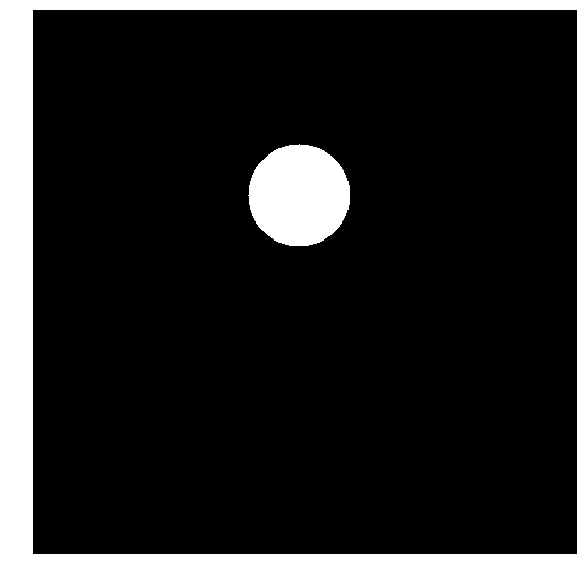

In [41]:
imm(testY[1,:,:,:].reshape([512,512]))

In [10]:
predicted_masks = model.predict(testX[:10],batch_size=1,verbose=1)

10/10 [==============================] - 34s 3s/step


In [54]:
predicted_masks.shape

(10, 512, 512, 1)

1
2
3
4
5
6
7
8
9


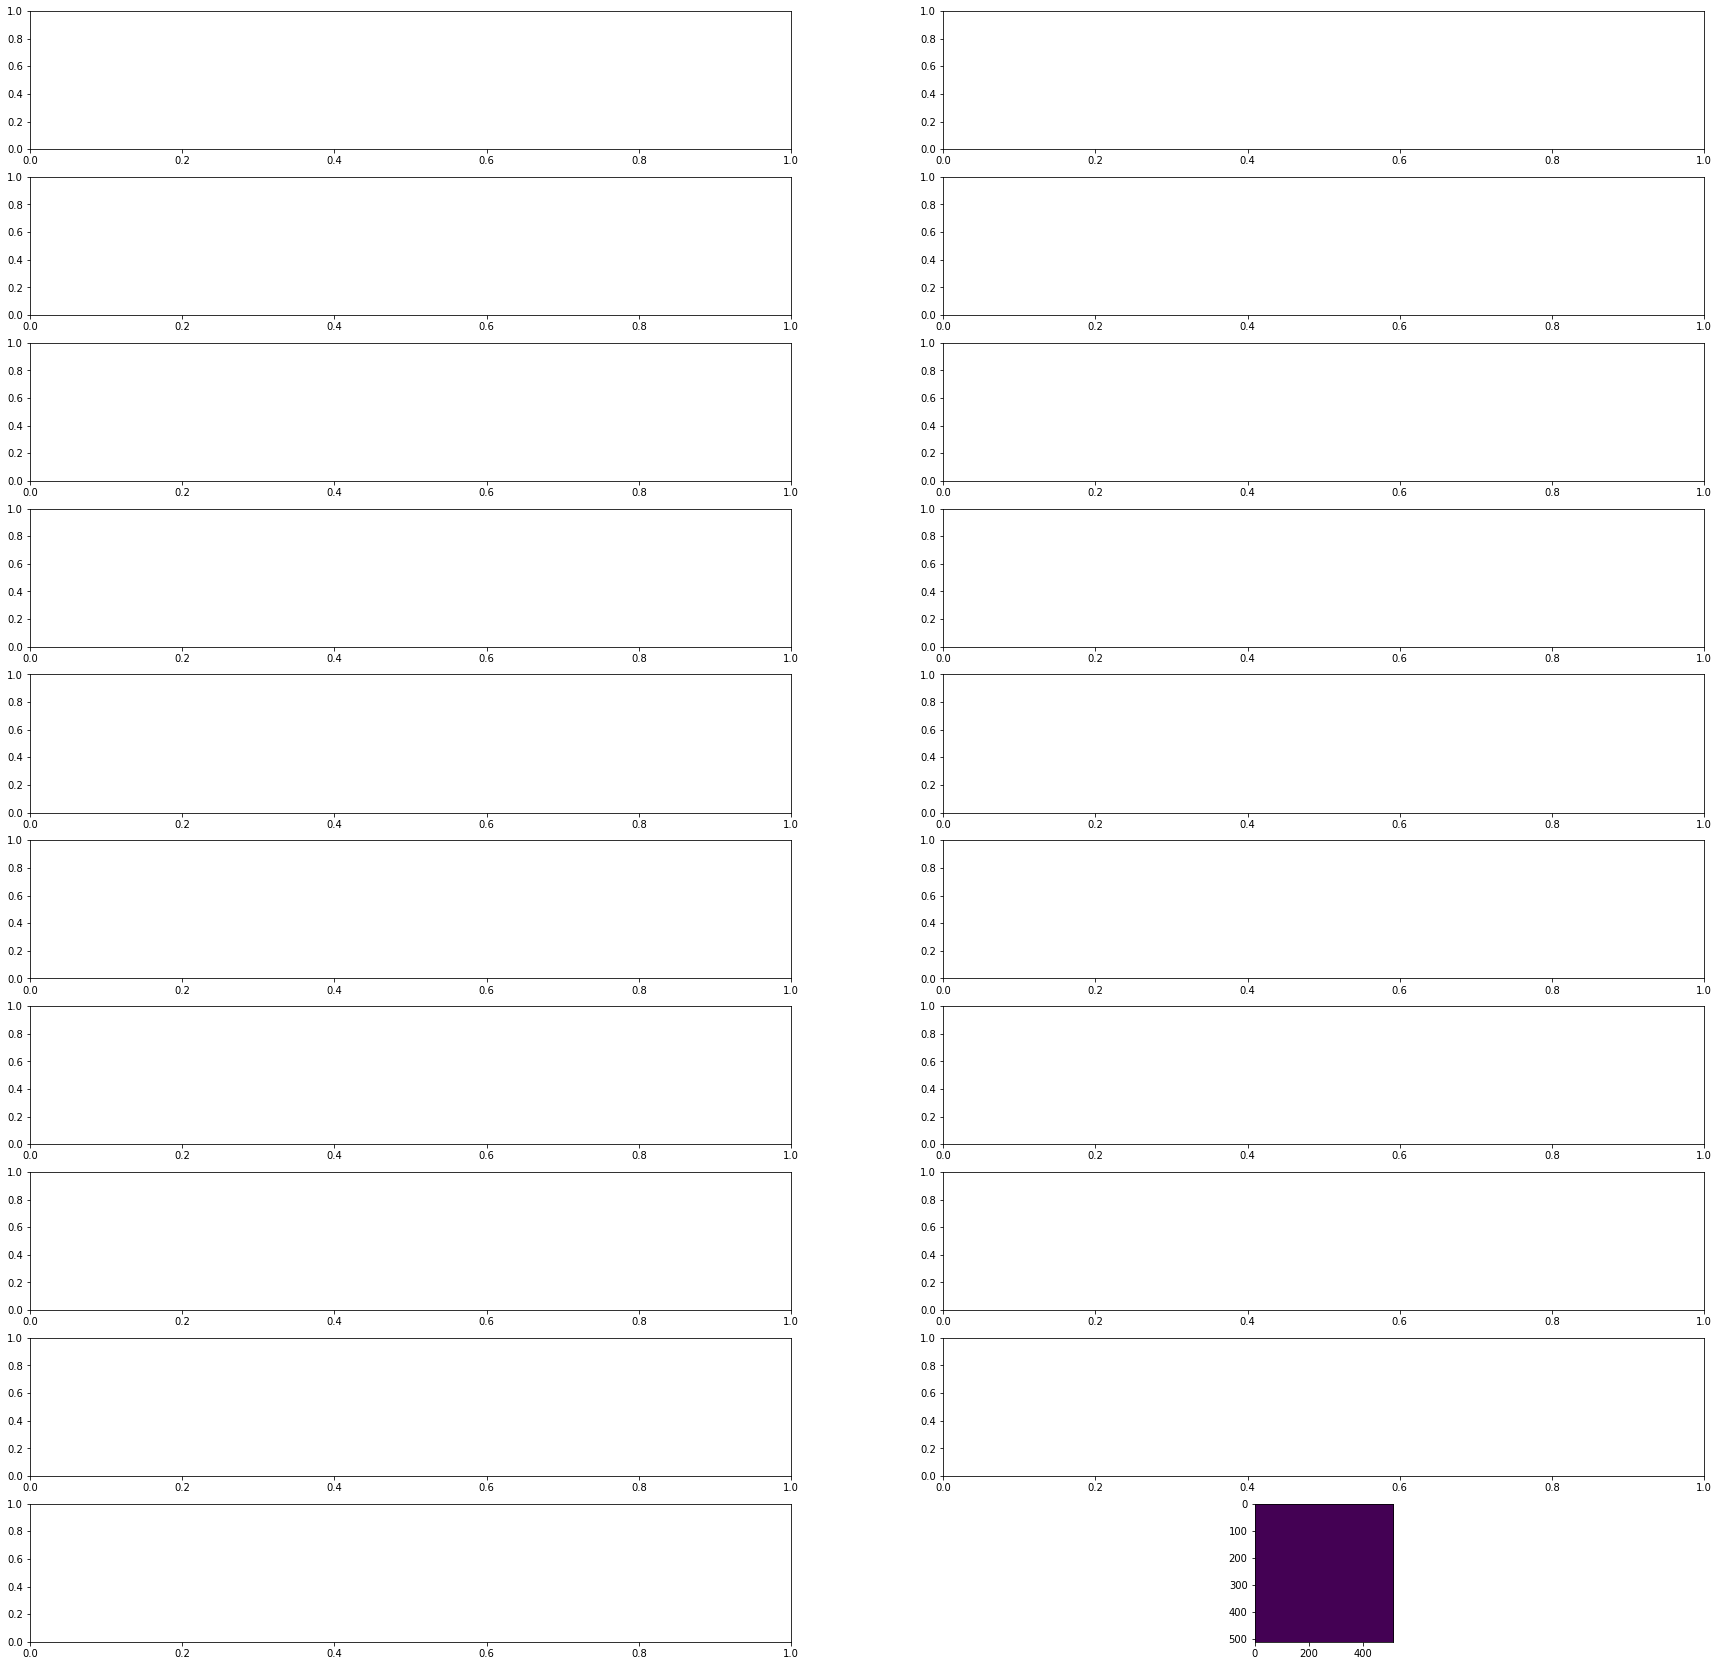

In [67]:
fig, axs = plt.subplots(10,2, figsize=(30, 30))
axs = axs.ravel()
for i in range(1,10):
    print(i)
    if i%2 != 0:
        axs[i-1] = plt.imshow(predicted_masks[i-1,:,:,:].reshape([512,512]))
    else:
        axs[i-1] = plt.imshow(testY[i-1,:,:,:].reshape([512,512]))

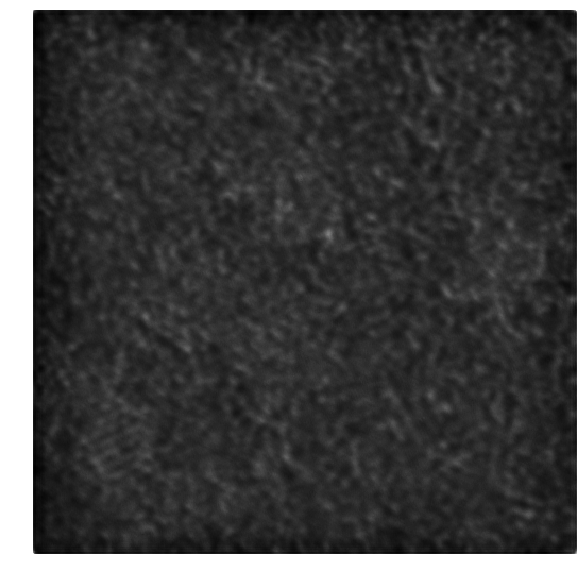

In [13]:
imm(predicted_masks[0,:,:,:].reshape([512,512]))

In [38]:
thres_mask = predicted_masks[0,:,:,:].reshape([512,512])
thres_mean = thres_mask.mean()
thres_mask[thres_mask> thres_mean] = 1
thres_mask[thres_mask < thres_mean] = 0

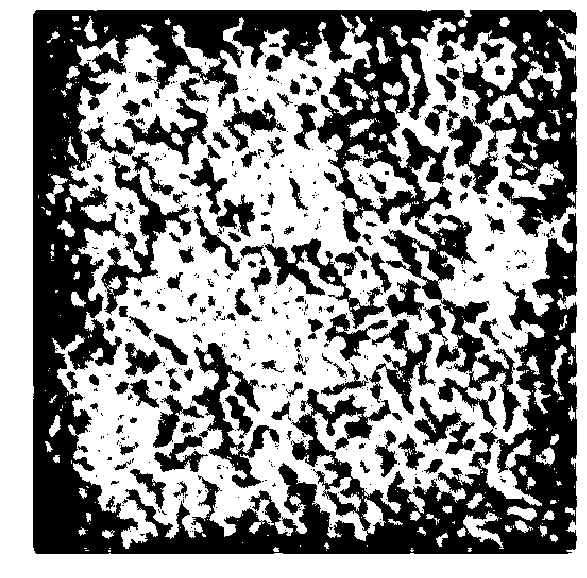

In [39]:
imm(thres_mask)

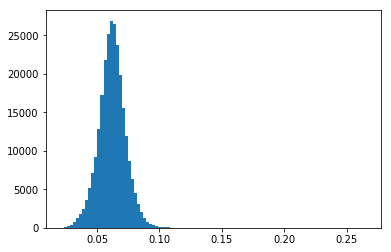

In [32]:
_ = plt.hist(predicted_masks[0,:,:,:].reshape([512,512]).flatten(),bins = 100)

In [33]:
predicted_masks[0,:,:,:].reshape([512,512]).mean()

0.06210838

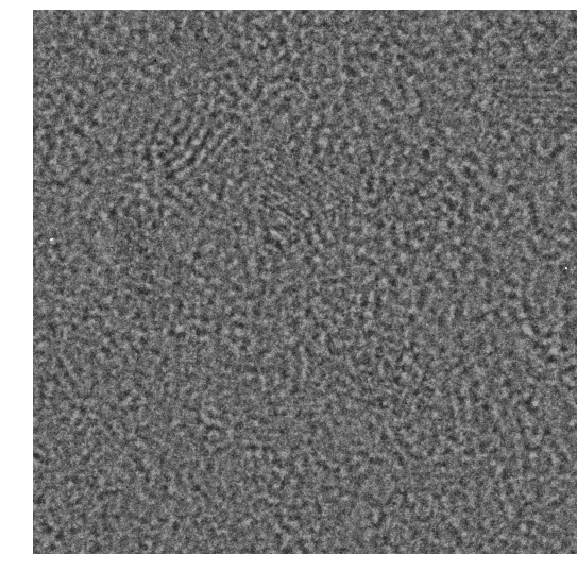

In [42]:
imm(testX[1,:,:,:].reshape([512,512]))

In [24]:
save_dir_pieces = directory.split('/')
save_dir = '/' +save_dir_pieces[0]
for idx, piece in enumerate(save_dir_pieces):
    if idx == 0:
        pass
    elif idx == len(save_dir_pieces)-1:
        pass
    else:
        save_dir += piece + '/'
       

In [25]:
save_dir

'/Users/cgroschner/Documents/pythonDev/particleRecognition/classfier_builds/'

In [26]:
model_path = save_dir + 'models/first_trained_model_unet1.h5'

In [27]:
model.save(model_path)

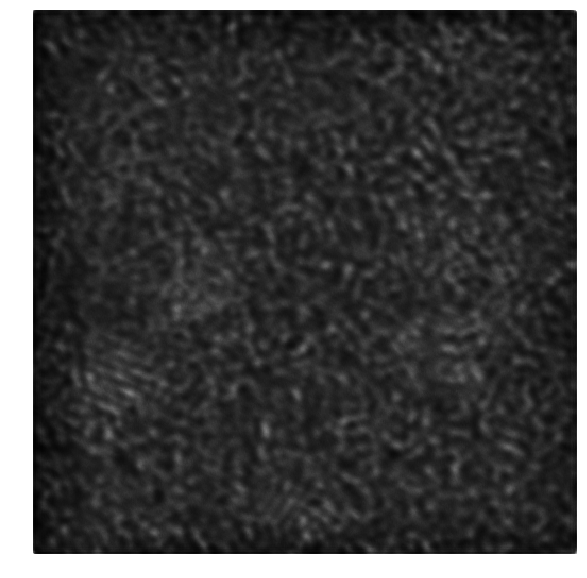

In [44]:
imm(predicted_masks[3,:,:,:].reshape([512,512]))

## CNN Take 2 - using smaller images (1024x1024) broken into 64x64

In [ ]:
image_files = glob(directory+'/sliced_images/*.png')
mask_files = glob(directory + '/sliced_labels/*.png')

split = int(len(image_files)*0.75)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append(np.copy(img))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)

testX = []
for file in image_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testX.append(np.copy(img))
testX = np.asanyarray(testX)

testY = []
for file in mask_files[split:]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    testY.append(np.copy(img))
testY = np.asanyarray(testY)

In [ ]:
inputs = Input((64,64,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
print("conv1 shape:",conv1.shape)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
print("conv1 shape:",conv1.shape)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print("pool1 shape:",pool1.shape)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
print("conv2 shape:",conv2.shape)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
print("conv2 shape:",conv2.shape)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print("pool2 shape:",pool2.shape)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
print("conv3 shape:",conv3.shape)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
print("conv3 shape:",conv3.shape)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print("pool3 shape:",pool3.shape)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])